# Sesión 1 - Apartado 5: Taller completo

En este taller aplicaremos todo lo aprendido hasta ahora:

- Limpieza de datos.
- Preprocesamiento de variables numéricas y categóricas.
- Ingeniería de características.
- Construcción de un pipeline completo.
- Evaluación inicial del modelo.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

import joblib

## 1. Carga de datos y visualización

- Usaremos el dataset `../data/raw/mini_titanic.csv` (columnas: sex, class, age, fare, survived).
- Carga el CSV con pandas y echa un vistazo con `head()` y `info()`.

In [3]:
# Dataset
# TODO: Carga el dataset mini_titanic
df = pd.read_csv('../data/raw/mini_titanic.csv')

# TODO: Visualiza las primeras filas
df.head()

,sex,class,age,fare,survived
0,male,Third,34.352706,119.00,0
1,female,Second,50.654987,66.77,0
2,male,First,42.007235,21.87,0
3,male,Second,27.760861,NaN,0
4,male,Third,29.733773,212.45,0


In [4]:
# TODO (opcional): Revisa tipos y nulos rápidos
print("\nInfo:")
df.info()
print("\nNulos por columna:")
print(df.isna().sum().sort_values(ascending=False))


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       300 non-null    object 
 1   class     285 non-null    object 
 2   age       265 non-null    float64
 3   fare      280 non-null    float64
 4   survived  300 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 11.8+ KB

Nulos por columna:
age         35
fare        20
class       15
sex          0
survived     0
dtype: int64


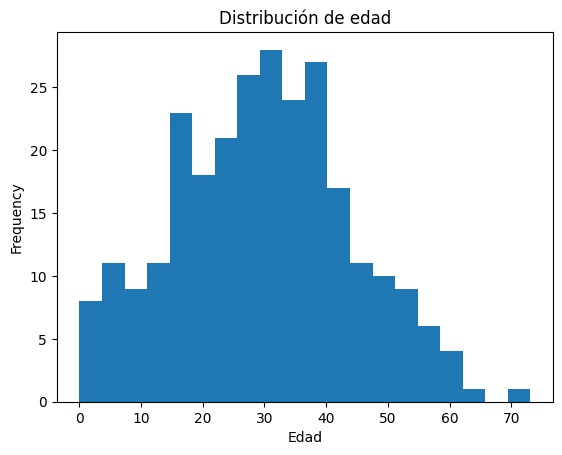

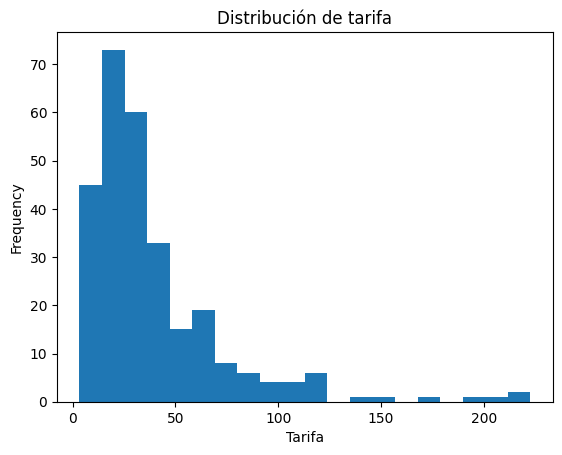

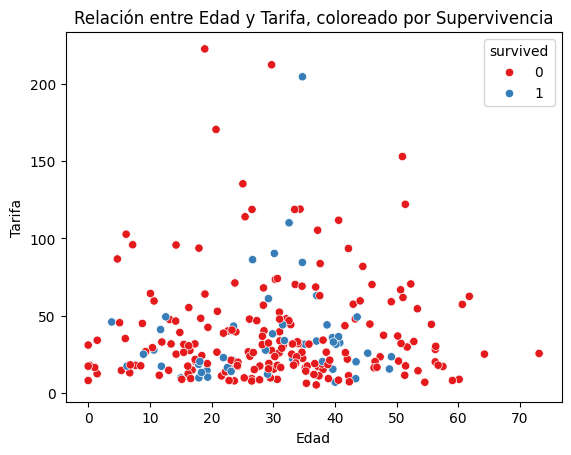

In [9]:
# Visualización de datos

# TODO: Visualiza la distribución de 'age' y/o 'fare' con histogramas
plt.figure()
df["age"].plot(kind="hist", bins=20, title="Distribución de edad")
plt.xlabel("Edad")
plt.show()

plt.figure()
df["fare"].plot(kind="hist", bins=20, title="Distribución de tarifa")
plt.xlabel("Tarifa")
plt.show()

# TODO: Visualiza la relación entre 'age' y 'fare' con un scatter plot, coloreado por 'survived'
plt.figure()
sns.scatterplot(data=df, x="age", y="fare", hue="survived", palette="Set1")
plt.title("Relación entre Edad y Tarifa, coloreado por Supervivencia")
plt.xlabel("Edad")
plt.ylabel("Tarifa")
plt.show()

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#TODO: Visualiza la distribución de 'age' y 'fare' con histogramas
fig, ax = plt.subplots(1, 2, figsize=(10,4))
_ = ax[0].hist(df['age'].dropna(), bins=20, color='steelblue', alpha=0.8)
ax[0].set_title('Distribución de age')
_ = ax[1].hist(df['fare'].dropna(), bins=20, color='orange', alpha=0.8)
ax[1].set_title('Distribución de fare')
plt.tight_layout()
plt.show()

#TODO: Visualiza la relación entre 'age' y 'fare' con un scatter plot, coloreado por 'survived'
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='age', y='fare', hue='survived', palette='coolwarm', alpha=0.8)
plt.title('age vs fare (coloreado por survived)')
plt.show()

In [10]:
# TODO: Define columnas y separa X e y
# Pista:
# target = 'survived'
# feature_cols = ['age','fare','sex','class']

target = 'survived'
feature_cols = ['age','fare','sex','class']

X = df[feature_cols]
y = df[target]

X.head(), y.head()

(         age    fare     sex   class
 0  34.352706  119.00    male   Third
 1  50.654987   66.77  female  Second
 2  42.007235   21.87    male   First
 3  27.760861     NaN    male  Second
 4  29.733773  212.45    male   Third,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: survived, dtype: int64)

## 3. Ingeniería de características personalizada

- Crea un transformador `FeatureEngineer` que añada features simples basadas en columnas existentes.
- Ideas (elige 1-2):
  - `Age_Fare` = age * fare (interacción numérica)
  - `Class_initial` = primera letra de `class`
  - `Fare_log` = log1p(fare)
- Implementa en el método `transform` y devuelve un DataFrame con las nuevas columnas.

In [11]:
# TODO: Implementa un transformador de ingeniería de características
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        # TODO: Crea 1-2 nuevas columnas. Ejemplos:
        # Interacción numérica
        if {'age','fare'}.issubset(X_.columns):
            X_['Age_Fare'] = X_['age'] * X_['fare']
        # Inicial de clase
        if 'class' in X_.columns:
            X_['Class_initial'] = X_['class'].astype(str).str[0]
        # Log del fare
        if 'fare' in X_.columns:
            X_['Fare_log'] = np.log1p(X_['fare'])
        return X_

## 4. Construcción del pipeline
Incluye:
- Imputación de nulos (numéricas: mediana; categóricas: más frecuente).
- Escalado de numéricas con StandardScaler.
- Codificación OneHot de categóricas con handle_unknown='ignore'.
- Ingeniería de características personalizada.
- Modelo final: LogisticRegression.

Notas:
- Columnas numéricas: `['age','fare']`
- Columnas categóricas: `['sex','class', 'Class_initial' (si la creaste)]`

In [12]:
# TODO: Define columnas por tipo (usa nombres correctos)
num_cols = ['age','fare']
cat_cols = ['sex','class']

# Numeric preprocessing
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# TODO: Preprocesamiento categórico
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# TODO: ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, [c for c in num_cols if c in X.columns]),
    ('cat', cat_transformer, [c for c in cat_cols if c in X.columns])
])

# TODO: Pipeline completo
pipe = Pipeline(steps=[
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

pipe

,steps,"[('feature_engineer', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 5. Evaluación con conjunto de prueba

- Separa train/test (20%) con `train_test_split`.
- Considera `stratify=y` para clases balanceadas.
- Entrena el pipeline y reporta `accuracy` en test.
- Extiende con métricas extra (opcional): matriz de confusión y classification_report.

Accuracy en test: 0.9333333333333333

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        47
           1       0.85      0.85      0.85        13

    accuracy                           0.93        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.93      0.93      0.93        60



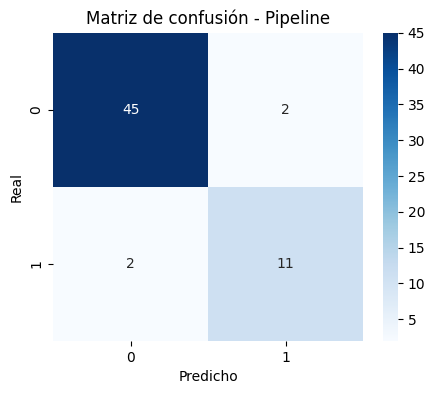

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
print("Accuracy en test:", pipe.score(X_test, y_test))

y_pred = pipe.predict(X_test)
print("\nClassification report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - Pipeline')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 6. Guardar y cargar el pipeline (opcional)

- Guarda el pipeline entrenado con `joblib.dump` en `../data/processed/titanic_pipeline.joblib`.
- Carga el pipeline y verifica el `score` en test.
- Esto simula el flujo de producción (S1_A3).

In [ ]:
# TODO: Guardar el pipeline entrenado
joblib.dump(pipe, "../../data/processed/titanic_pipeline.joblib")

# TODO: Cargar el pipeline y evaluar
pipe_loaded = joblib.load("../../data/processed/titanic_pipeline.joblib")
print("Accuracy cargado:", pipe_loaded.score(X_test, y_test))

Accuracy cargado: 0.9333333333333333
